In [1]:
%pip install transformers datasets rouge_score accelerate bert_score

Note: you may need to restart the kernel to use updated packages.


In [2]:
from datasets import load_dataset

dataset = load_dataset("json", data_files="./data/amicorpus.jsonl", split="train")
dataset = dataset.train_test_split(test_size=0.1)


Generating train split: 0 examples [00:00, ? examples/s]

In [3]:
import torch
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.get_device_name(0))  # Should print your GPU name


True
NVIDIA GeForce GTX 1660 SUPER


In [4]:
from transformers import BartTokenizer, BartForConditionalGeneration

cache_dir = "./models/bart-base"
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base", cache_dir=cache_dir)
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base", cache_dir=cache_dir)

model.to("cuda")


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

BartForConditionalGeneration(
  (model): BartModel(
    (shared): BartScaledWordEmbedding(50265, 768, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(50265, 768, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_lay

In [5]:
max_input_length = 1024
max_target_length = 128

def preprocess(example):
    model_inputs = tokenizer(
        example["transcript"],
        max_length=max_input_length,
        padding="max_length",
        truncation=True
    )
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            example["summary"],
            max_length=max_target_length,
            padding="max_length",
            truncation=True
        )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_dataset = dataset.map(preprocess, batched=True)


Map:   0%|          | 0/124 [00:00<?, ? examples/s]

d:\anaconda\envs\notesum\lib\site-packages\transformers\tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/14 [00:00<?, ? examples/s]

In [6]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./models/bart-summarizer",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=10,
    predict_with_generate=True,
    fp16=True,
    logging_dir="./logs",
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
)


d:\anaconda\envs\notesum\lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\Dinh Vu Anh\AppData\Local\Temp\ipykernel_23176\2809488367.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [7]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,2.715132
2,No log,2.582969
3,No log,2.574184
4,No log,2.568320
5,No log,2.548259
6,No log,2.573570
7,No log,2.625762
8,No log,2.633763
9,No log,2.650526
10,No log,2.656233


d:\anaconda\envs\notesum\lib\site-packages\transformers\modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=310, training_loss=2.2273411904611895, metrics={'train_runtime': 1104.1415, 'train_samples_per_second': 1.123, 'train_steps_per_second': 0.281, 'total_flos': 756073208217600.0, 'train_loss': 2.2273411904611895, 'epoch': 10.0})

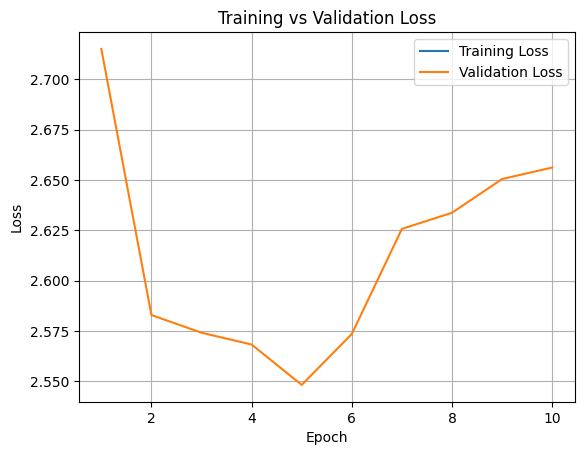

In [8]:
import matplotlib.pyplot as plt

# Extract loss values
logs = trainer.state.log_history
train_loss = [log["loss"] for log in logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in logs if "eval_loss" in log]
epochs_train = [log["epoch"] for log in logs if "loss" in log]
epochs_eval = [log["epoch"] for log in logs if "eval_loss" in log]

# Plotting
plt.plot(epochs_eval, eval_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# import random

# # Decode sample predictions from eval set
# eval_dataset = trainer.eval_dataset
# preds_output = trainer.predict(eval_dataset)
# preds = tokenizer.batch_decode(preds_output.predictions, skip_special_tokens=True)
# labels = tokenizer.batch_decode(preds_output.label_ids, skip_special_tokens=True)

# # Visualize 3 random samples
# for _ in range(3):
#     idx = random.randint(0, len(preds) - 1)
#     print(f"\n[Sample {idx}]")
#     print("Input Prompt:")  # You can print the original input too if you saved it
#     print(tokenizer.decode(eval_dataset[idx]["input_ids"], skip_special_tokens=True))
#     print("\nGround Truth Summary:")
#     print(labels[idx])
#     print("\nPredicted Summary:")
#     print(preds[idx])


In [10]:
import numpy as np
import evaluate
from bert_score import score as bert_score

# Load ROUGE metric
rouge = evaluate.load("rouge")

def compute_metrics(eval_preds):
    preds, labels = eval_preds

    # Decode predictions and labels
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Strip whitespaces to improve ROUGE/BERTScore
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [label.strip() for label in decoded_labels]

    # Compute ROUGE
    rouge_result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    rouge_metrics = {k: round(v * 100, 2) for k, v in rouge_result.items()}

    # Compute BERTScore
    P, R, F1 = bert_score(decoded_preds, decoded_labels, lang="en", rescale_with_baseline=True)
    bertscore_metrics = {
        "bertscore_precision": round(P.mean().item() * 100, 2),
        "bertscore_recall": round(R.mean().item() * 100, 2),
        "bertscore_f1": round(F1.mean().item() * 100, 2),
    }

    # Combine and return both
    return {**rouge_metrics, **bertscore_metrics}

# Assign to trainer
trainer.compute_metrics = compute_metrics


In [11]:
trainer.evaluate()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 2.656233072280884,
 'eval_rouge1': 21.44,
 'eval_rouge2': 11.08,
 'eval_rougeL': 16.46,
 'eval_rougeLsum': 16.36,
 'eval_bertscore_precision': 46.72,
 'eval_bertscore_recall': 2.41,
 'eval_bertscore_f1': 23.7,
 'eval_runtime': 18.0705,
 'eval_samples_per_second': 0.775,
 'eval_steps_per_second': 0.221,
 'epoch': 10.0}

In [12]:
trainer.save_model("./models/meetingSum-bart")
tokenizer.save_pretrained("./models/meetingSum-bart")

('./models/meetingSum-bart\\tokenizer_config.json',
 './models/meetingSum-bart\\special_tokens_map.json',
 './models/meetingSum-bart\\vocab.json',
 './models/meetingSum-bart\\merges.txt',
 './models/meetingSum-bart\\added_tokens.json')